In [1]:
#If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

#In addition, uncomment and run the following code:
# !pip install pzflow

#Intro to pzflow

#This notebook demonstrates building a normalizing flow with pzflow to learn the joint probability distribution of some 2-D data.#

#You do not need to have any previous knowledge of normalizing flows to get started with pzflow, however if you are interested, here are some good sources:

#    Eric Jang's tutorial: part 1, part 2
#    Here is a comprehensive list of papers, blogs, videos, and packages
#    Two good intro papers using Coupling Layers: NICE, Real NVP
#    The paper on Neural Spline Couplings

import jax.numpy as np
import matplotlib.pyplot as plt

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import galaxy_data
from pzflow.distributions import Uniform, Joint, Normal
import pandas as pd
import GCRCatalogs
import timeit
import numpy as onp

In [2]:
cosmo=GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small_with_photozs_v1")

In [3]:
quantities = ['galaxy_id', 'redshift', 'ra', 'dec','mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0', 
     'size_true', 'size_minor_true', 'morphology/totalSersicIndex', 
     'morphology/totalEllipticity', 'stellar_mass', 'totalStarFormationRate', 'position_angle_true', 'mag_err_u_photoz', 'mag_err_g_photoz', 'mag_err_r_photoz', 'mag_err_i_photoz', 'mag_err_z_photoz', 'mag_err_y_photoz']
filters=['redshift<1', 'Mag_true_r_sdss_z0<-15.']

In [5]:
gal = cosmo.get_quantities(quantities, filters)

In [9]:
data_unscaled = {}
data_unscaled['logSFRtot'] = np.log10(gal['totalStarFormationRate'])
data_unscaled['redshift']  = gal['redshift']
data_unscaled['morphology/totalSersicIndex'] = gal['morphology/totalSersicIndex']
data_unscaled['size_true'] = gal['size_true']
data_unscaled['logmass'] = np.log10(gal['stellar_mass'])
data_unscaled['Mag_true_g_sdss_z0']  = gal['Mag_true_g_sdss_z0']
data_unscaled['Mag_true_r_sdss_z0']  = gal['Mag_true_r_sdss_z0']
data_unscaled['Mag_true_i_sdss_z0']  = gal['Mag_true_i_sdss_z0']
data_unscaled['Mag_true_z_sdss_z0']  = gal['Mag_true_z_sdss_z0']
data_unscaled['galaxy_id'] = gal['galaxy_id']
data_unscaled['ra'] = gal['ra']
data_unscaled['dec'] = gal['dec']
data_unscaled['morphology/totalEllipticity'] = gal['morphology/totalEllipticity']

In [10]:
data_unscaled = pd.DataFrame(data_unscaled)

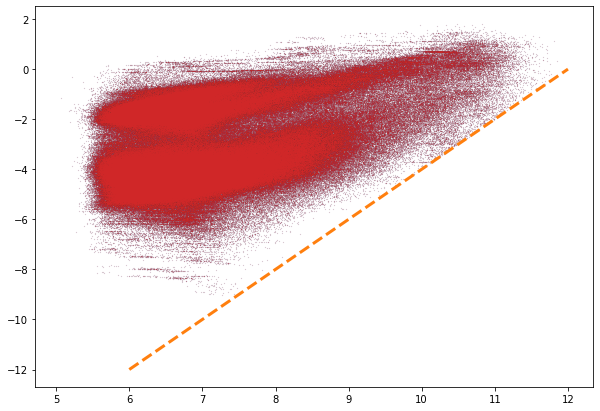

In [11]:
def f(logmass):
    return 2*logmass - 24

#get rid of that weird clump M* > 10^10 Msol and logSFR = -5
data_unscaled = data_unscaled[onp.asarray((data_unscaled['logSFRtot'] - 9) > f(data_unscaled['logmass']))]
x = np.linspace(6,12)
plt.figure(figsize=(10,7))
plt.plot(data_unscaled['logmass'].values[::30],data_unscaled['logSFRtot'].values[::30]-9,'o', ms=0.1, alpha=0.6)
plt.plot(data_unscaled['logmass'].values[::30],data_unscaled['logSFRtot'].values[::30]-9,'o', c='tab:red', ms=0.1, alpha=0.6)
plt.plot(x, f(x), ls='--', lw=3)

In [12]:
data_unscaled['g-r'] = data_unscaled['Mag_true_g_sdss_z0'] - data_unscaled['Mag_true_r_sdss_z0']
data_unscaled['r-i'] = data_unscaled['Mag_true_r_sdss_z0'] - data_unscaled['Mag_true_i_sdss_z0']
data_unscaled['i-z'] = data_unscaled['Mag_true_i_sdss_z0'] - data_unscaled['Mag_true_z_sdss_z0']


In [13]:
# standard scale the reference magnitude and colors
data = data_unscaled.copy()
for quality in ['morphology/totalSersicIndex', 'size_true',
        'logmass', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0', 'g-r', 'r-i', 'i-z']:
    data[quality] = (data_unscaled[quality]-data_unscaled[quality].mean())/data_unscaled[quality].std()

In [14]:
data = data[['redshift', 'logSFRtot', 'morphology/totalSersicIndex', 'size_true',
        'logmass', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0', 'g-r', 'r-i', 'i-z']]

In [15]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks


#split into 10 chunks
data_list = split_dataframe(data, chunk_size=int(len(data)/1.e2))

data_subset = data.sample(n=int(len(data)/1.e2))



In [16]:
data_subset.head()


redshift  logSFRtot  morphology/totalSersicIndex  size_true  \
12272543  0.583259   7.636993                    -0.736385   0.915841   
6402576   0.955759   5.300599                    -0.736385   0.120272   
10549600  0.577675   6.770536                     1.136001  -0.583879   
18731136  0.995785   4.222482                    -0.736385   0.315238   
8057447   0.867357   5.129617                    -0.736385  -0.261224   

           logmass  Mag_true_g_sdss_z0  Mag_true_r_sdss_z0  \
12272543 -0.448099            0.534195            0.465169   
6402576   1.022192           -1.171764           -1.293422   
10549600 -0.878511            1.137414            1.075261   
18731136 -0.822136            0.668741            0.578752   
8057447  -0.525151            0.001616            0.127520   

          Mag_true_i_sdss_z0  Mag_true_z_sdss_z0       g-r       r-i       i-z  
12272543            0.389294            0.342005  0.438847  1.121267  0.810331  
6402576            -1.319881           -1.319095  1.139969  0.814903  0.551707  
10549600            1.002472            0.953351  0.281327  0.892434  0.584266  
18731136            0.544684            0.531905  0.576951  0.395646  0.029611  
8057447             0.187020            0.222609 -0.969925 -1.022867 -0.816881

In [17]:
conditional_columns = data_subset.columns.drop(['redshift', 'logSFRtot'])
latent = Joint(Uniform((-3,3)), Normal(1))
means = np.array([0.5, data_subset['logSFRtot'].mean()])
stds = np.array([1/5.9, data_subset['logSFRtot'].std()]) #switched 1/6 to 1/5.9
bijector = Chain(
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, n_conditions=10),
)
flow = Flow(
    data_columns = ("redshift", "logSFRtot"),
    conditional_columns = ('morphology/totalEllipticity', 'size_true',
        'logmass', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0r', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0', 'g-r', 'r-i', 'i-z'),
    bijector = bijector,
    latent = latent,          
)

In [18]:
# To create the conditional flow, we have to provide
# 1. The names of the data columns
# 2. The bijector
# 3. The names of the conditional columns
flow = Flow(['redshift', 'logSFRtot'], bijector, conditional_columns=data_subset.columns.drop(['redshift', 'logSFRtot']))


In [19]:
%%time
losses = flow.train(data_subset, epochs=30, verbose=True)


Training 30 epochs 
Loss:
2.9167
-1.0121
-1.2224
-1.2824
-1.2905
-1.2915
-1.3526
-1.2240
-1.3336
-1.3247
-1.3828
-1.4405
-1.4784
-1.4784
-1.5199
-1.4448
-1.4269
-1.5237
-1.5003
-1.5233
-1.4860
-1.5359
-1.4742
-1.5189
-1.5871
-1.5515
-1.5524
-1.5701
-1.5645
-1.5624
-1.5260
CPU times: user 5min 40s, sys: 44.4 s, total: 6min 24s
Wall time: 2min


Text(0, 0.5, 'Training loss')

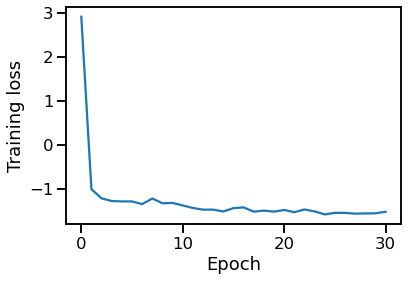

In [20]:
import seaborn as sns
sns.set_context("talk")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
#plt.savefig("TrainingLoss_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [24]:
len(data_subset)

290870

In [23]:
flow.save('../data_files/pzflow_dc2small_1hundredth')

In [25]:
samples = flow.sample(1, conditions=data_subset, seed=0)

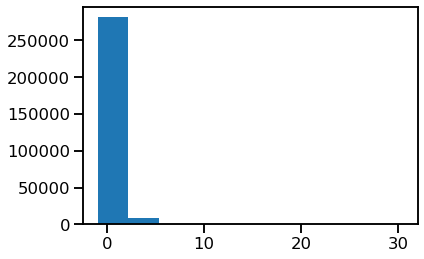

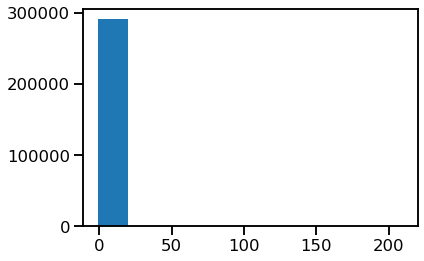

In [26]:
plt.hist(data_subset['size_true'])
plt.show()
plt.hist(data_list[0]['size_true'])
plt.show()

In [27]:
allSamples = []
for chunk in data_list:
    samples = flow.sample(1, conditions=chunk, seed=0)
    allSamples.append(samples)

In [28]:
samples=pd.concat(allSamples)
# samples = allSamples_DF.copy()

In [37]:
len(samples)

29087019

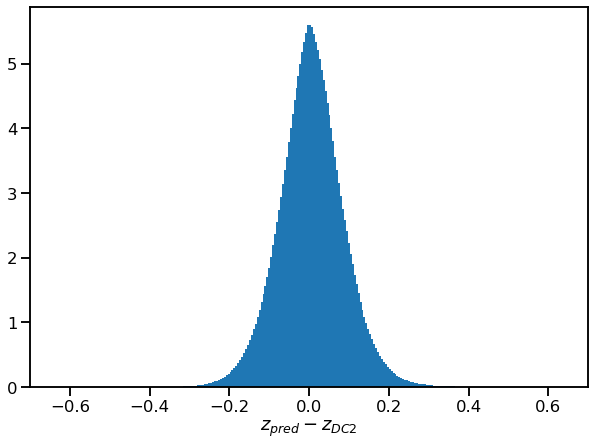

In [29]:
plt.figure(figsize=(10,7))
plt.hist(samples['redshift'].values - data['redshift'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
plt.xlim((-0.7, 0.7))
plt.xlabel(r"$z_{pred} - z_{DC2}$");
#plt.savefig("zPred_vs_zDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

Text(0, 0.5, 'logSFRtot')

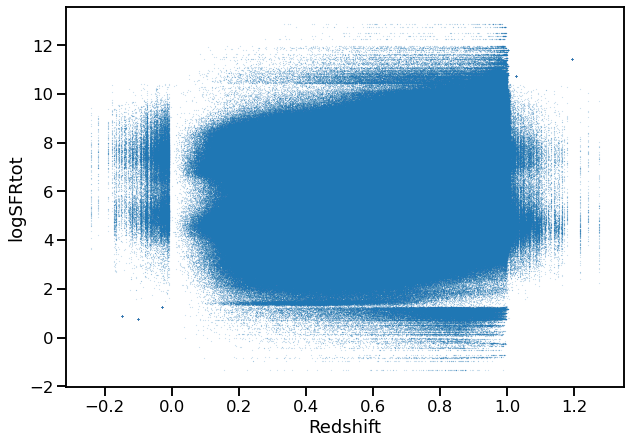

In [30]:
plt.figure(figsize=(10,7))
plt.plot(samples['redshift'], samples['logSFRtot'], 'o', ms=0.08)
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_pzFlowOnly.png",dpi=300, bbox_inches='tight')

In [31]:
len(samples[samples['redshift']>1.0])/len(samples)*100

0.3918552121136924

In [32]:
len(samples[samples['redshift']<0.0])/len(samples)*100

0.12721826186451074

In [33]:
samples_small = samples[(samples['Mag_true_r_sdss_z0'] < -2.) & (samples['Mag_true_r_sdss_z0'] > -3.)]
data_full_small = data[(data['Mag_true_r_sdss_z0'] < -2.) & (data['Mag_true_r_sdss_z0'] > -3.)]

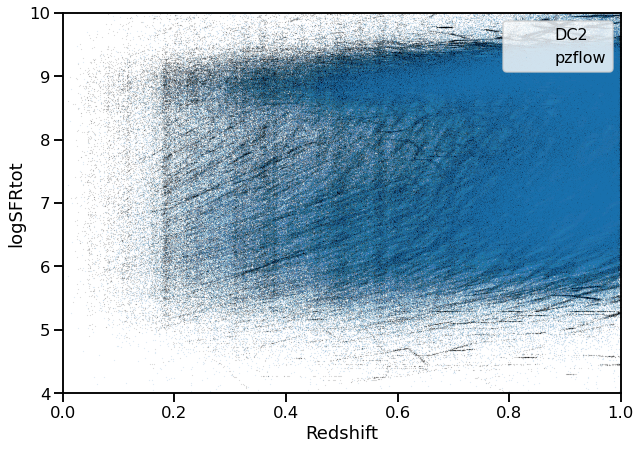

In [34]:
plt.figure(figsize=(10,7))
plt.plot(data_full_small['redshift'], data_full_small['logSFRtot'], 'o', ms=0.05, label='DC2', c='k')
plt.plot(samples_small['redshift'], samples_small['logSFRtot'], 'o', ms=0.05, label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
plt.legend(fontsize=16, loc='upper right')
#plt.savefig("SFR_vs_Redshift_pzFlow.png",dpi=300, bbox_inches='tight')

Text(0, 0.5, 'logSFRtot')

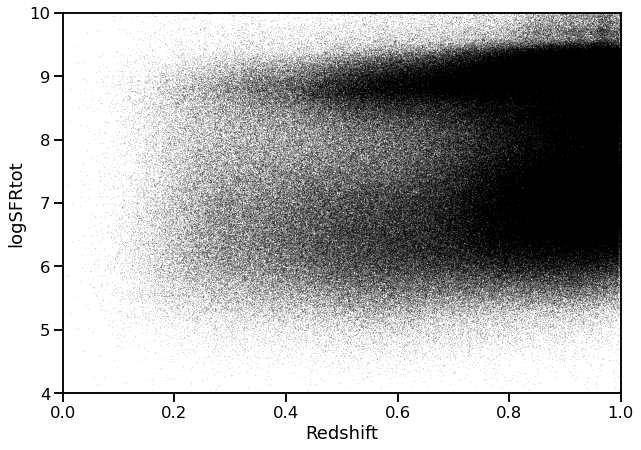

In [35]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(samples_small['redshift'], samples_small['logSFRtot'], 'o', ms=0.05, c='k', label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_justPZFlow.png",dpi=300, bbox_inches='tight')

Text(0, 0.5, 'logSFRtot')

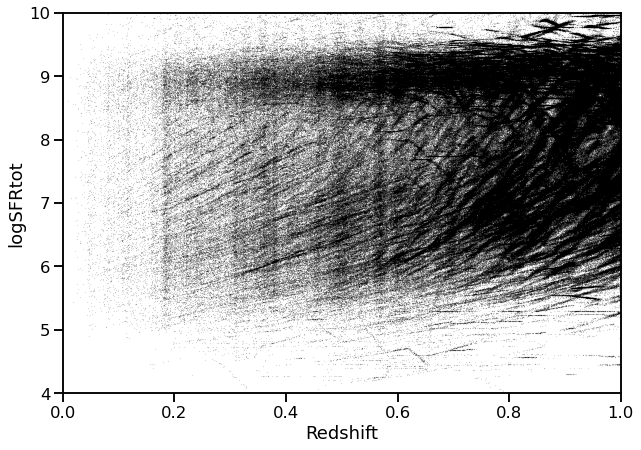

In [36]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(data_full_small['redshift'], data_full_small['logSFRtot'], 'o', ms=0.05, label='DC2', c='k')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_justDC2.png",dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,7))
plt.hist(samples['logSFRtot'].values - data['logSFRtot'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
plt.axvline(x=0, c='r')
plt.xlim((-3, 3))
plt.xlabel(r"$logSFRtot_{pred} - logSFRtot_{DC2}$");
#plt.savefig("SFRtotPred_vs_SFRtotDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,7))
plt.hist(samples['logSFRtot'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
#plt.xlim((-0.7, 0.7))
plt.xlabel(r"$logSFRtot_{pred}$")
#plt.savefig("SFRtotPred_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,7))
plt.hist(samples['redshift'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
#plt.xlim((-0.7, 0.7))
plt.xlabel(r"$z_{pred}$")
#plt.savefig("zPred_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [ ]:
#RUNNING UP TO HERE 03/07/2021!!

In [ ]:
# samples[['redshift', 'logSFRtot']].to_csv("samples_newRedshift_SFR.csv",index=False)

In [ ]:
data['DC2redshift'] = data['redshift'].values
data['PZflowredshift'] = samples['redshift'].values

data['DC2SFRtot'] = 10**(data['logSFRtot'].values)
data['PZflowSFRtot'] = 10**(samples['logSFRtot'].values)

data['stellar_mass'] = 10**(data['logmass'].values)
del data['redshift']
del data['logSFRtot']
del data['logmass']

In [ ]:
data

In [ ]:
data_full_save = data[['galaxy_id','ra','dec',
          'DC2redshift',
          'PZflowredshift',
          'Mag_true_g_sdss_z0',
          'Mag_true_r_sdss_z0',
          'Mag_true_i_sdss_z0',
          'Mag_true_z_sdss_z0', 
          'morphology/totalSersicIndex',
          'size_true',
          'morphology/totalEllipticity',
          'stellar_mass',
          'DC2SFRtot', 
          'PZflowSFRtot']]


In [ ]:
#truncate for quality cuts
data_full_save_cut = data_full_save[(data_full_save['PZflowredshift']>=0.0) & (data_full_save['PZflowredshift']<=1.0)]


In [ ]:
data_full_save_cut = data_full_save_cut[(data_full_save_cut['PZflowSFRtot'] > 1.e1) & (data_full_save_cut['PZflowSFRtot'] < 1.e10)]


In [ ]:
data_full_save_cut.to_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DC2_pzRedshifts_SFR_0to50.csv",index=False)


In [68]:
len(data_full_save_cut)/len(data_full)

0.9941790124752233

In [43]:
samples.to_csv("./samples_conditionalRedshift.csv",index=False)

In [42]:
#re-load data
data_full_save_cut = pd.read_csv("./DC2_pzRedshifts_SFR.csv", low_memory=True)

In [40]:
logSFR_data = np.log10(data_full_save_cut['DC2SFRtot'].sample(n=5000))
logSFR_samples = np.log10(data_full_save_cut['PZflowSFRtot'].sample(n=5000))

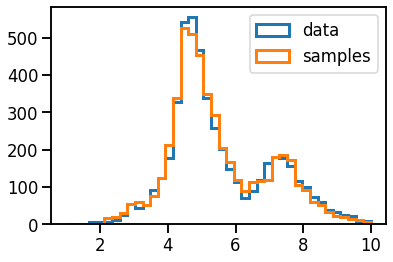

In [61]:
plt.hist(logSFR_data, range=(1, 10),bins=40,  histtype='step', label='data',lw=3)
plt.hist(logSFR_samples, range=(1, 10),bins=40,  histtype='step', label='samples',lw=3)
plt.legend()
plt.savefig("SFR_conditionalSampling.png",dpi=200, bbox_inches='tight')

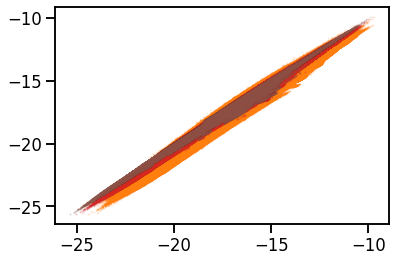

In [63]:
#truncate a few more outliers
import numpy as np 
for band in ['Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0']:
    m, b = np.polyfit(data_full_save_cut[band], data_full_save_cut['Mag_true_z_sdss_z0'], 1)
    samples_outliers = data_full_save_cut[np.abs((m*data_full_save_cut[band] + b) - data_full_save_cut['Mag_true_z_sdss_z0']) > 1.3]
    samples_inliers = data_full_save_cut[np.abs((m*data_full_save_cut[band] + b) - data_full_save_cut['Mag_true_z_sdss_z0']) < 1.3]
    plt.plot(samples_outliers[band], samples_outliers['Mag_true_z_sdss_z0'], 'o', ms=2)
    plt.plot(samples_inliers[band], samples_inliers['Mag_true_z_sdss_z0'], 'o', ms=1, alpha=0.1)

    data_full_save_cut =  data_full_save_cut[np.abs((m*data_full_save_cut[band] + b) - data_full_save_cut['Mag_true_z_sdss_z0']) < 1.3]

In [49]:
plt.hist(data['redshift'], range=(0, 1.0), bins=40, histtype='step', label='data')
plt.hist(samples['redshift'], range=(0, 1.0), bins=40, histtype='step', label='samples')
plt.legend()
plt.savefig("Histogram_z_allProperties_ConditionalZSFR.png",dpi=200)

NameError: name 'data' is not defined

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

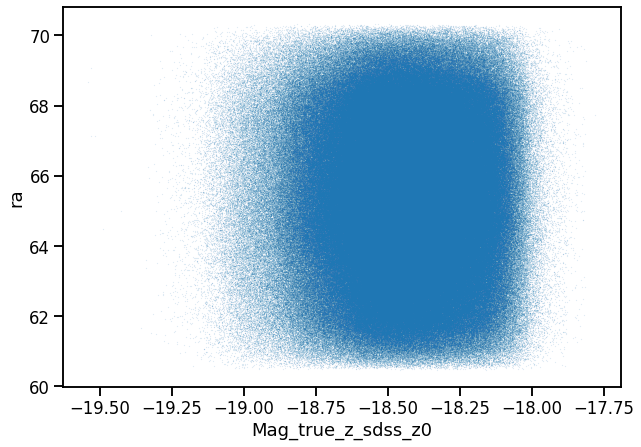

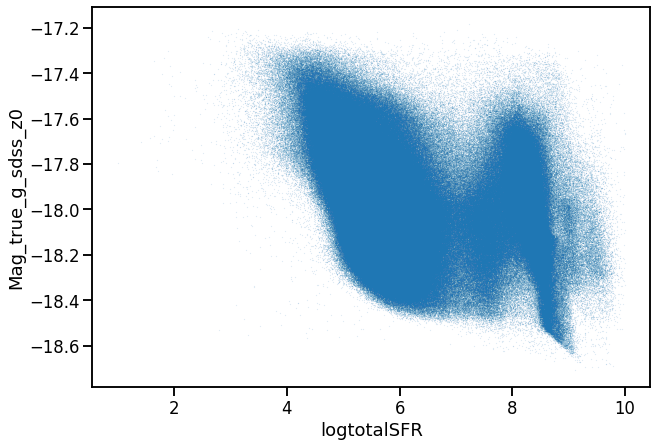

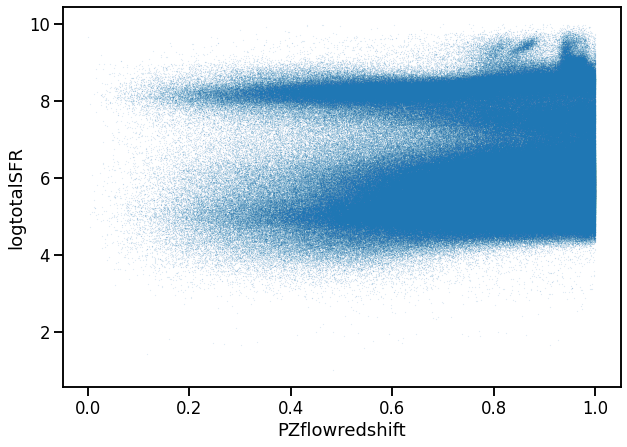

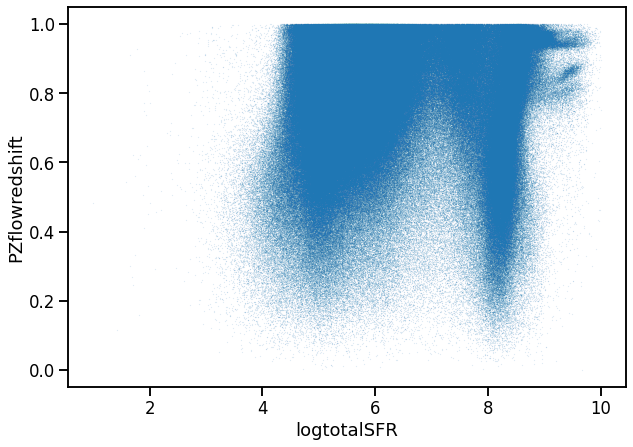

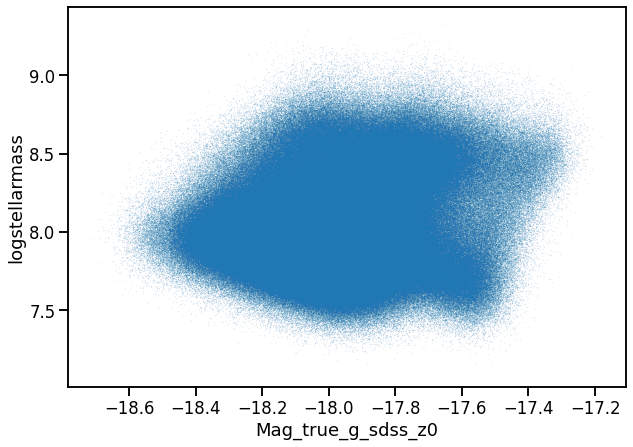

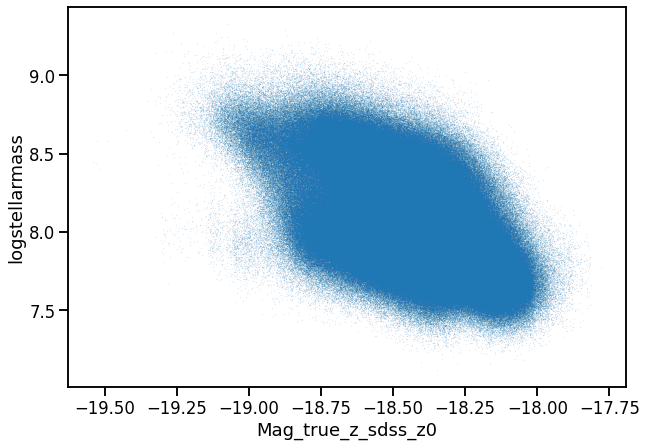

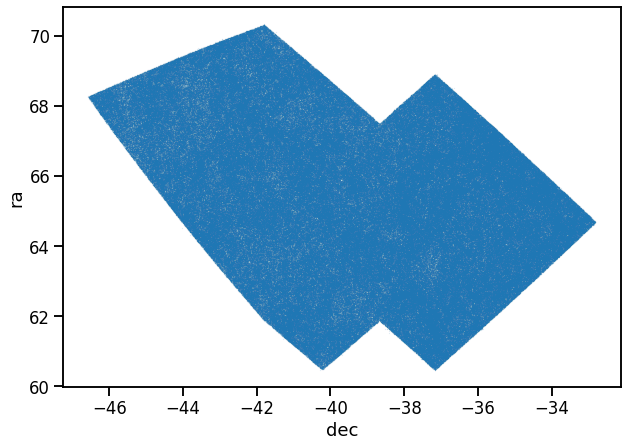

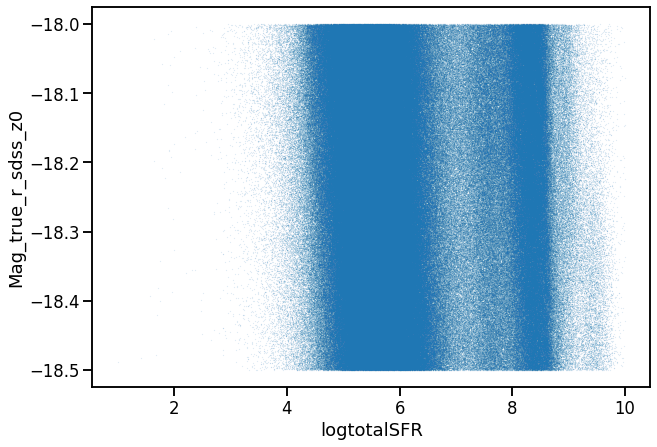

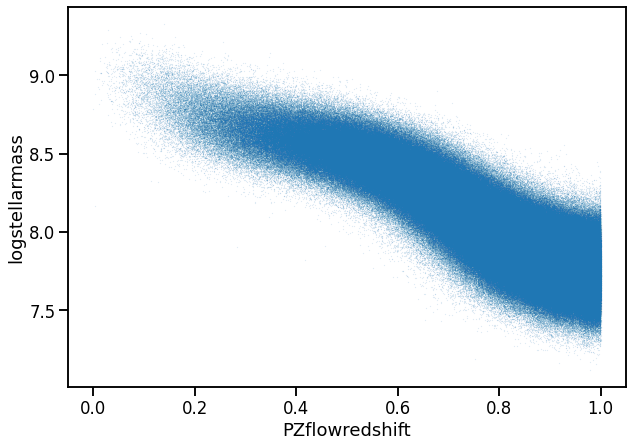

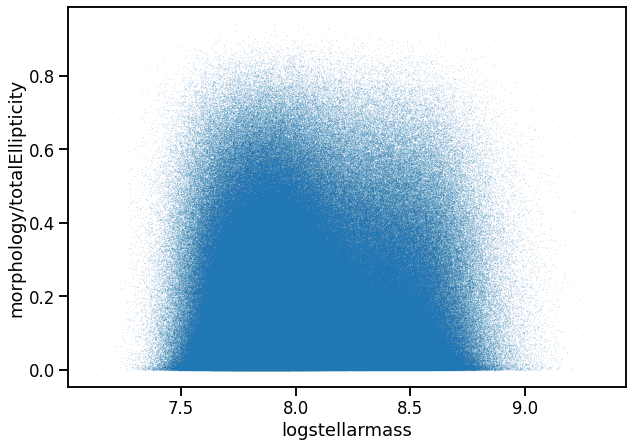

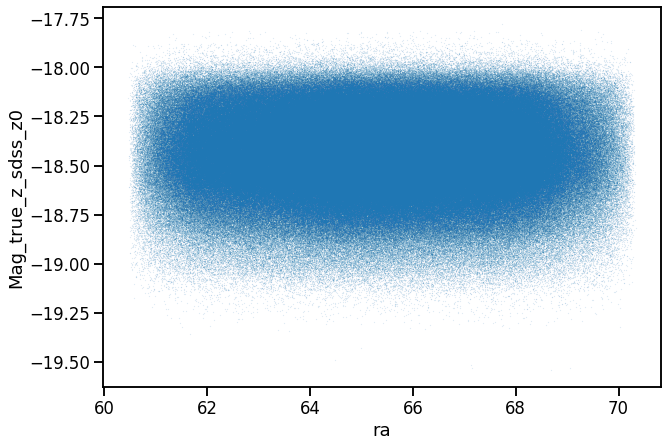

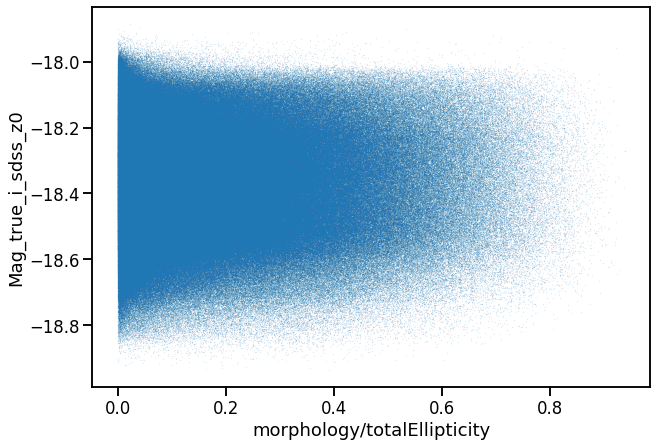

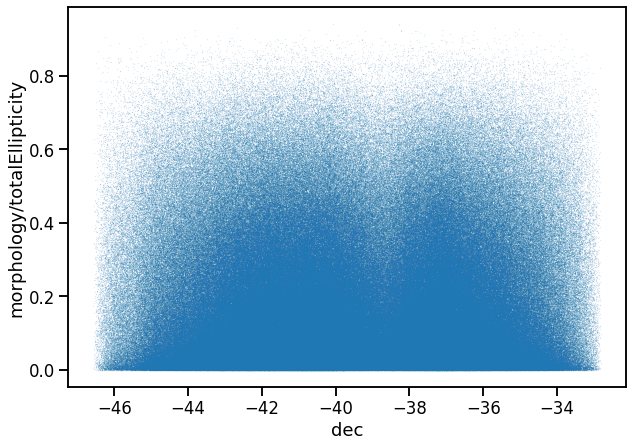

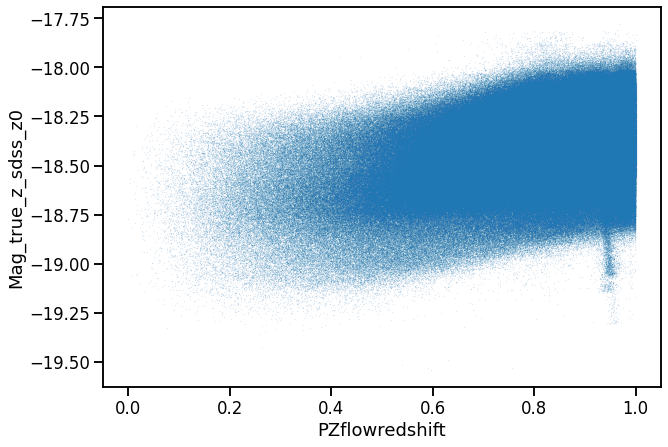

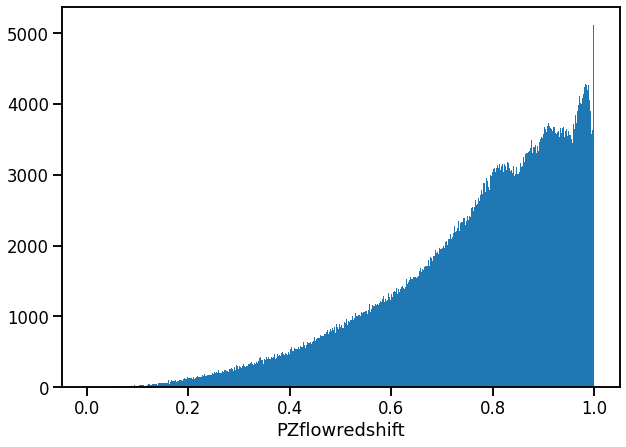

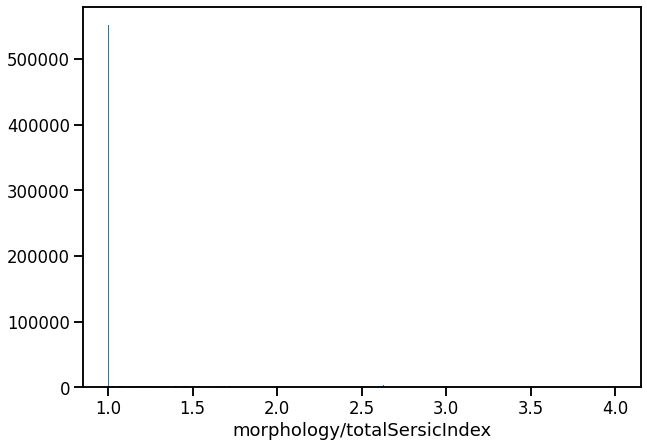

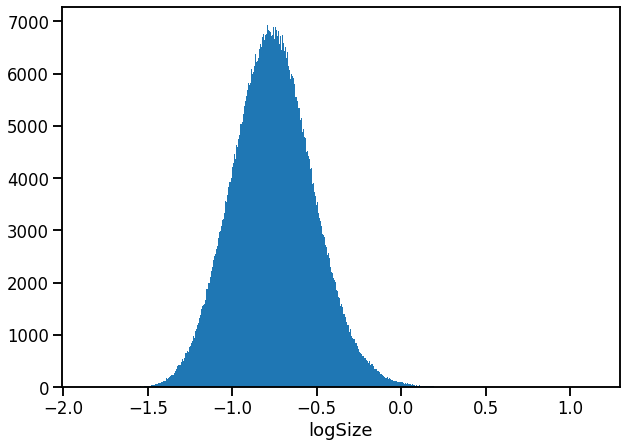

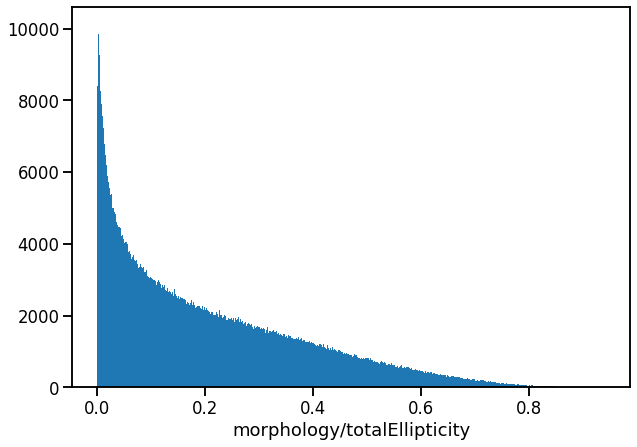

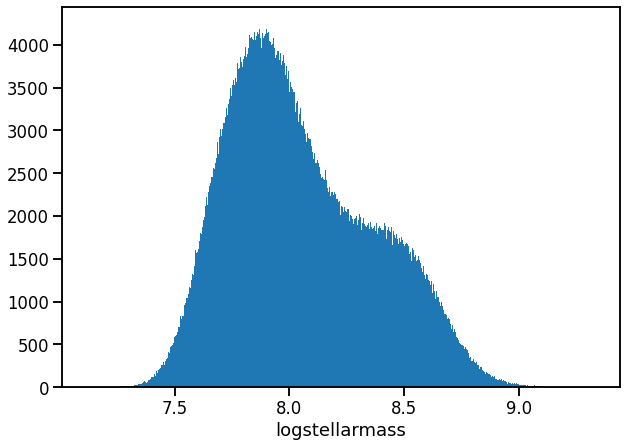

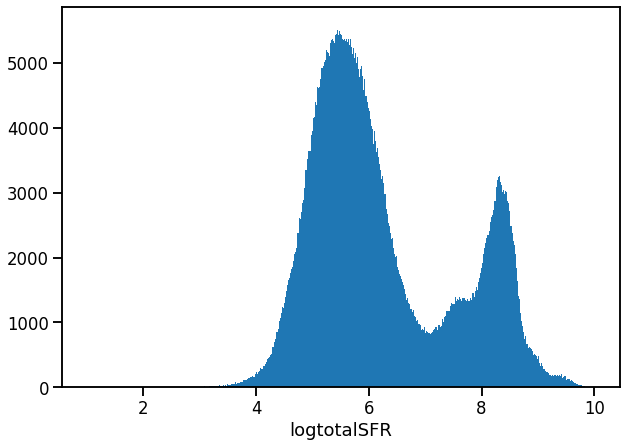

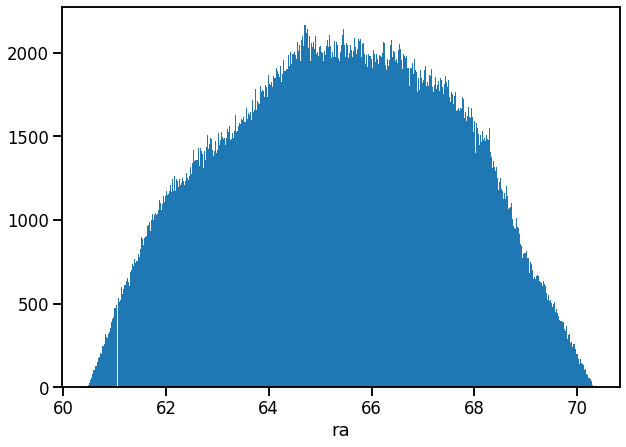

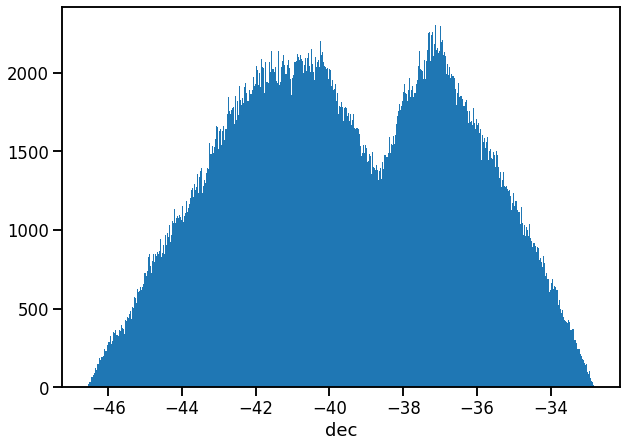

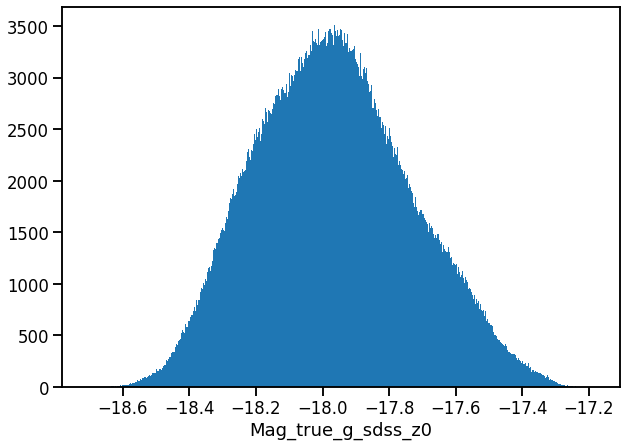

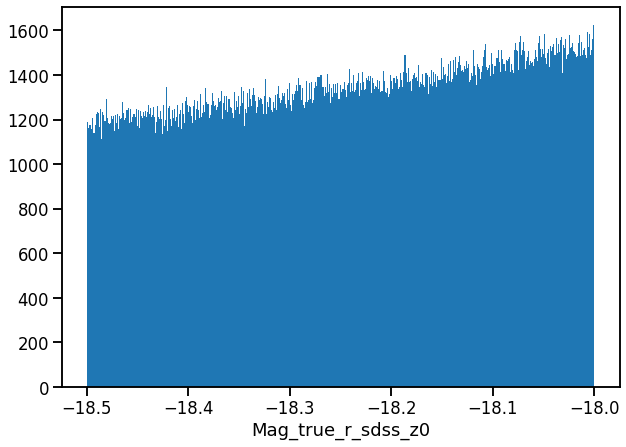

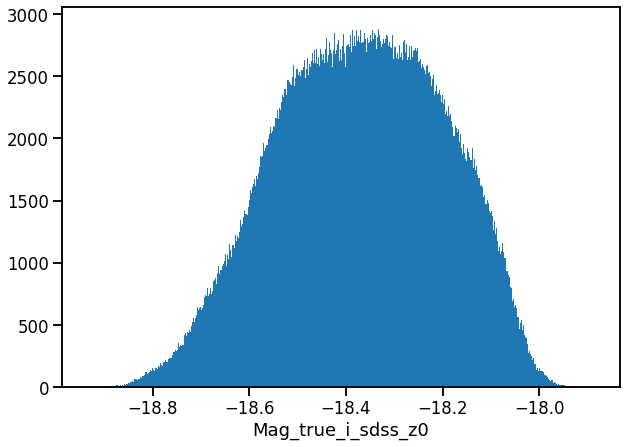

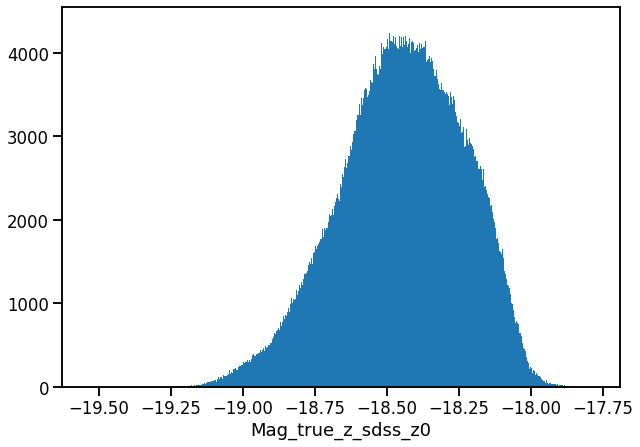

In [60]:
import seaborn as sns
import random
data_cut = data_full_save_cut[(data_full_save_cut['Mag_true_r_sdss_z0'] < -18) & ((data_full_save_cut['Mag_true_r_sdss_z0'] > -18.5))]
sns.set_context("talk")

data_cut['logstellarmass'] = np.log10(data_cut['stellar_mass'])
data_cut['logtotalSFR'] = np.log10(data_cut['PZflowSFRtot'])
data_cut['logSize'] = np.log10(data_cut['size_true'])

params = ['PZflowredshift', 'morphology/totalSersicIndex','logSize',
          'morphology/totalEllipticity','logstellarmass','logtotalSFR','ra','dec', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0']
data_cut = data_cut[params]

for i in np.arange(15):
    idx1 = random.randint(0, len(params)-1)
    idx2 = random.randint(0, len(params)-1)
    if idx1 == idx2:
        continue
    plt.figure(figsize=(10,7))
    plt.plot(data_cut[params[idx1]], data_cut[params[idx2]],'o',ms=0.05)
    plt.xlabel(params[idx1])
    plt.ylabel(params[idx2])
    plt.show()

for i in np.arange(len(params)):
    vals = data_cut[params[i]]
    vals.replace([np.inf, -np.inf], np.nan, inplace=True) #drop inf
    vals = vals[vals == vals] #drop na
    plt.figure(figsize=(10,7))
    plt.hist(vals, bins=int(1.e3))
    plt.xlabel(params[i])

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

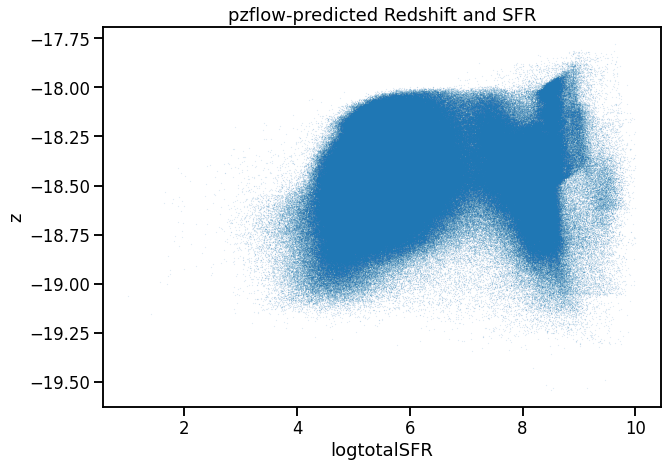

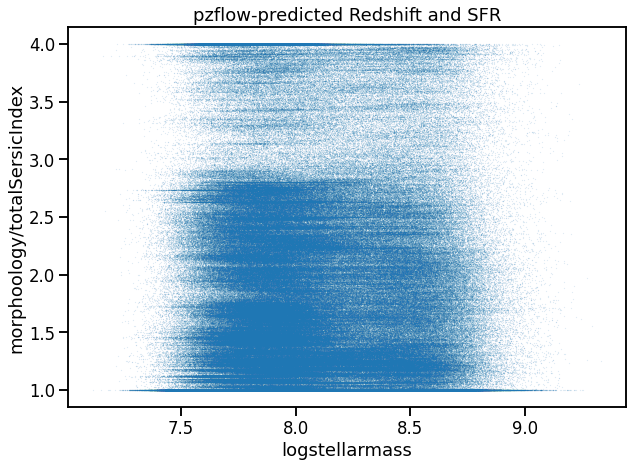

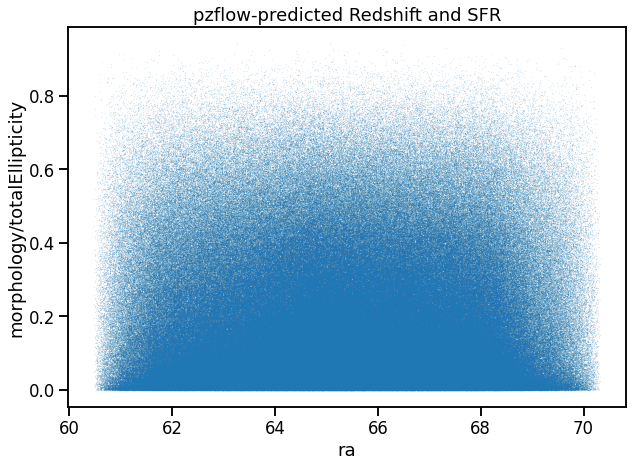

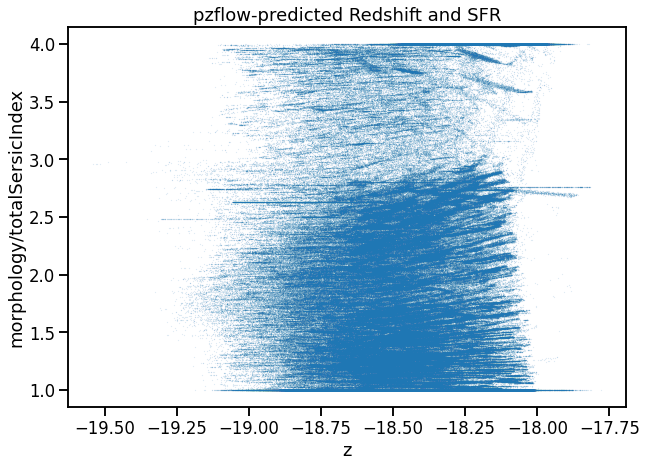

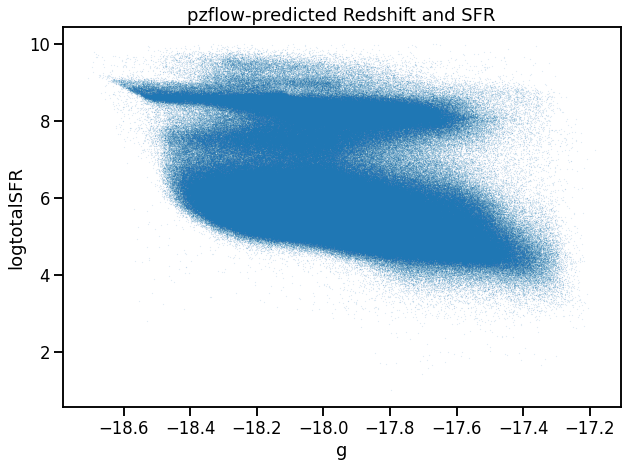

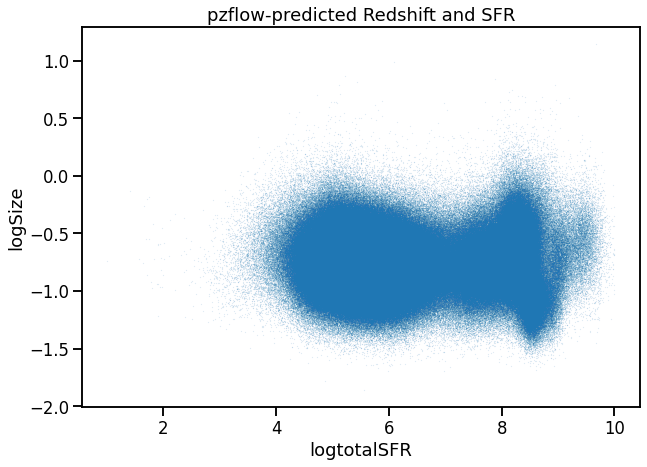

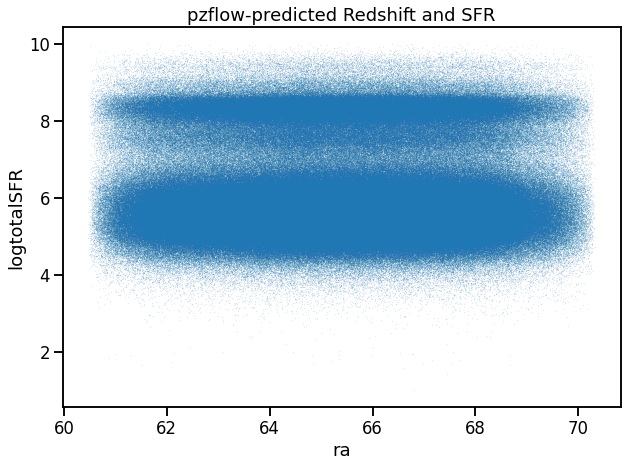

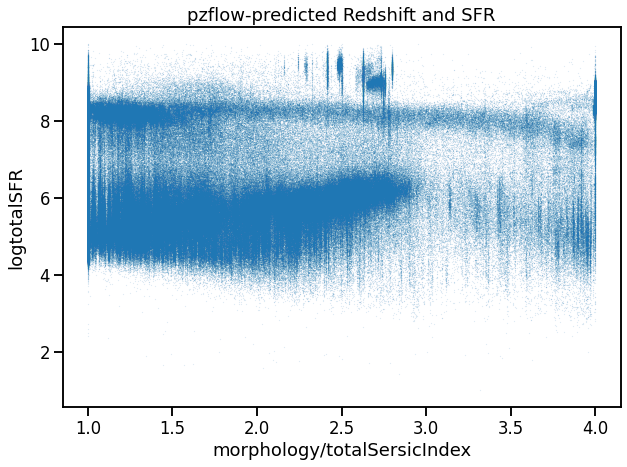

In [55]:
import seaborn as sns
import random
data_cut = data_full_save_cut[(data_full_save_cut['Mag_true_r_sdss_z0'] < -18) & ((data_full_save_cut['Mag_true_r_sdss_z0'] > -18.5))]
sns.set_context("talk")

data_cut['logstellarmass'] = np.log10(data_cut['stellar_mass'])
data_cut['logtotalSFR'] = np.log10(data_cut['PZflowSFRtot'])
data_cut['logSize'] = np.log10(data_cut['size_true'])
data_cut['g'] = data_cut['Mag_true_g_sdss_z0']
data_cut['r'] = data_cut['Mag_true_r_sdss_z0']
data_cut['i'] = data_cut['Mag_true_i_sdss_z0']
data_cut['z'] = data_cut['Mag_true_z_sdss_z0']

params = ['PZflowredshift', 'DC2redshift', 'morphology/totalSersicIndex','logSize',
          'morphology/totalEllipticity','logstellarmass','logtotalSFR','ra','dec', 'g', 'r', 'i', 'z']
data_cut = data_cut[params]

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['logtotalSFR'], data_cut['z'],'o',ms=0.05)
plt.xlabel("logtotalSFR")
plt.ylabel("z")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['logstellarmass'], data_cut['morphology/totalSersicIndex'],'o',ms=0.05)
plt.xlabel("logstellarmass")
plt.ylabel("morphoology/totalSersicIndex")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['ra'], data_cut['morphology/totalEllipticity'],'o',ms=0.05)
plt.xlabel("ra")
plt.ylabel("morphology/totalEllipticity")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['z'], data_cut['morphology/totalSersicIndex'],'o',ms=0.05)
plt.xlabel("z")
plt.ylabel("morphology/totalSersicIndex")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['g'], data_cut['logtotalSFR'],'o',ms=0.05)
plt.xlabel("g")
plt.ylabel("logtotalSFR")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['logtotalSFR'], data_cut['logSize'],'o',ms=0.05)
plt.xlabel("logtotalSFR")
plt.ylabel("logSize")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['ra'], data_cut['logtotalSFR'],'o',ms=0.05)
plt.xlabel("ra")
plt.ylabel("logtotalSFR")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['morphology/totalSersicIndex'], data_cut['logtotalSFR'],'o',ms=0.05)
plt.xlabel("morphology/totalSersicIndex")
plt.ylabel("logtotalSFR")
plt.show()